Computing star shapes, shape correlation functions, and rho statistics
======================================================================

This code demonstrates how to measure star and PSF shapes from the object catalogs and how to compute shape-shape correlation functions.  It has a few steps:
 - Load a star catalog and a galaxy catalog from the imaging area
 - Load the extragalactic catalog and truth catalog over the same area
 - Match the imaging and EGC catalogs 
 - Measure the galaxy-galaxy shear correlation functions of the two galaxy catalogs
 - Measure the "rho statistics" -- correlation functions of the PSF and star shapes that diagnose PSF leakage into the cosmic shear signal
 - Measure the calibration factors that remove measurement bias from the shape measurement on images
 - Correct the galaxy-galaxy shear CF from the imaging data and compare the corrected version to the EGC CF
 - Measure the correlation function of the EGC over the same area, using all EGC galaxies reweighted to the same size and flux distribution as the measured galaxies, to further look for selection bias
 
Many of these steps borrow heavily from other DC2 tutorials, as listed in the code comments.

Note that--because we are loading many catalogs and performing a lot of processing on them that may not be vectorized--this notebook can take longer than you might expect to run, a few minutes per tract per catalog just to load the catalogs.

We begin by loading up the code we'll need. Stile will eventually be in the DESC environment but you may need to load it by hand at first by adding the path to sys.path.  The desc-stack kernel is most likely to have the dependencies you need for this tutorial.

In [1]:
import warnings
import sys
sys.path.insert(0, '')
# Could not get this to work with anything less specific...
sys.path.insert(0, '/global/homes/m/msimet/.local/lib/python3.6/site-packages')
sys.path.insert(0, '/global/homes/f/flanusse/repo/Stile')
sys.path.insert(0, '/global/homes/f/flanusse/repo/gcr-catalogs/')

import numpy as np
import pandas as pd
import FoFCatalogMatching
import lsst.afw.geom as afw_geom
import lsst.daf.persistence as dp
import GCRCatalogs
from GCR import GCRQuery
from desc_dc2_dm_data import REPOS
#from utils.fieldRotator import FieldRotator

import matplotlib.pyplot as plt
import scipy.optimize as op

with warnings.catch_warnings():
    # Stile throws up a bunch of matplotlib warnings that we can just ignore
    warnings.filterwarnings('ignore')
    import stile

figsize_x, figsize_y = plt.gcf().get_size_inches()

%matplotlib inline

Getting star shapes
-------------------

This next object demonstrates how to compute star shapes from the object catalogs.  You will need the measured _moments_: Ixx, Ixy, and Iyy.  These are measured in a reference frame that is local to the tracts and patches that the DM stack uses for analysis.  To compare to the galaxy shapes (which are in sky coordinates, relative to the (ra, dec) direction), we also need to rotate to the sky coordinate system using the butler.  

To perform this, we'll set up a ShearRotator class that takes in the moment data and reproduces the quantities we want.  Note that, per the notation sometimes used by lensing people (and, in particular, used by Stile), "sigma" is a linear measurement of size, and not a measurement error.

In [2]:
class ShearRotator:
    """ A class to compute distortions from moments, and optionally to rotate the results.  The outputs
        of the DM stack are in the local coordinate frame used for coaddition, but we want sky coordinates
        relative to ra and dec).  This class will store the info needed to rotate the moments (Ixx, Iyy, 
        Ixy, or IxxPSf, IyyPSF, IxyPSF) and additionally compute errors, if the covariance matrices are 
        also provided (Cxx etc).  Each desired quantity has a different function (g1, g2, sigma, and their
        errors) but heavy computations are stored to facilitate faster returns.
        
        If you want to use a ShearRotator for multiple catalogs (that is, multiple positions),
        then you MUST call ShearRotator.clear() between catalogs to remove the saved versions of the 
        rotated moments.
        
        Note that sigma is given in units of arcsec^2!
        
        Parameters
        ----------
        butler: lsst.daf.persistence.Butler
            A butler from which to retrieve the calibrated exposures and WCS
        tractId: int
            The number of the desired tract
        ra: array_like
            An array of right ascensions
        dec: array_like
            An array of declinations
        Ixx: array_like
            An array of Ixx (the (0,0) component of a moments matrix)
        Iyy: array_like
            An array of Iyy (the (1,1) component of a moments matrix)
        Ixy: array_like
            An array of Ixy (the (0,1) component of a moments matrix)
        Cxx: array_like
            An array of Cxx (the (0,0) component of a moments covariance matrix). Can be None
            if no errors will be computed.
        Cyy: array_like
            An array of Cyy (the (1,1) component of a moments covariance matrix). Can be None
            if no errors will be computed.
        Cxy: array_like
            An array of Cxy (the (0,1) component of a moments covariance matrix). Can be None
            if no errors will be computed.
        convert_to_sky_coords: bool
            Whether to rotate to sky coordinates or leave in native coordinates (default: True)
       """
    def __init__(self, butler, tractId, ra, dec, Ixx, Iyy, Ixy, Cxx=None, Cyy=None, Cxy=None, 
                       convert_to_sky_coords=True):
            
        self.ra = ra
        self.dec = dec
        if convert_to_sky_coords:
            skymap = butler.get('deepCoadd_skyMap')
            self.wcs = skymap[tractId].getWcs()
            self.makeTransform()
        else:
            self.wcs = None
        
        self.Ixx, self.Iyy, self.Ixy = self.makeRotatedMoments(Ixx, Iyy, Ixy)
        self.Cxx, self.Cyy, self.Cxy = self.makeRotatedCovariance(Cxx, Cyy, Cxy)
        
    def makeTransform(self):
        centroids = [afw_geom.Point2D(tra, tdec) for tra, tdec in zip(self.ra, self.dec)]
        self.transforms = [self.wcs.linearizePixelToSky(centroid, afw_geom.degrees).getLinear()
                                           for centroid in centroids]

    def makeRotatedMoments(self, Ixx, Iyy, Ixy):
        if self.wcs:
            ellipses = [afw_geom.ellipses.Quadrupole(tixx, tiyy, tixy) 
                        for tixx, tiyy, tixy in zip(Ixx, Iyy, Ixy)]
            moments = [ellipse.transform(lt) for ellipse, lt in zip(ellipses, self.transforms)]
            Ixx = np.array([mom.getIxx() for mom in moments])
            Ixy = np.array([mom.getIxy() for mom in moments])
            Iyy = np.array([mom.getIyy() for mom in moments])
        return Ixx, Iyy, Ixy
    
    def makeRotatedCovariance(self, Cxx, Cyy, Cxy):
        if self.wcs and Cxx is not None:
            cov_ixx = np.zeros(Cxx.shape)
            cov_iyy = np.zeros(Cxx.shape)
            cov_ixy = np.zeros(Cxx.shape)
            for i, (tcxx, tcxy, tcyy, lt) in enumerate(zip(Cxx, Cxy, Cyy, self.transforms)):
                cov_ixx[i] = (lt[0,0]**4*tcxx +
                              (2.*lt[0,0]*lt[0,1])**2*tcyy + lt[0,1]**4*tcxy)
                cov_iyy[i] = (lt[1,0]**4*tcxx +
                              (2.*lt[1,0]*lt[1,1])**2*tcyy + lt[1,1]**4*tcxy)
                cov_ixy[i] = ((lt[0,0]*lt[1,0])**2*tcxx +
                              (lt[0,0]*lt[1,1]+lt[0,1]*lt[1,0])**2*tcyy +
                              (lt[0,1]*lt[1,1])**2*tcxy)
            return cov_ixx, cov_iyy, cov_ixy
        return Cxx, Cyy, Cxy
    
    def g1(self):
        return (self.Ixx-self.Iyy)/(self.Ixx+self.Iyy)

    def g2(self):
        return 2.*self.Ixy/(self.Ixx+self.Iyy)
    
    def sigma(self):
        return 3600*(self.Ixx*self.Iyy - self.Ixy**2)**0.25 #3600: in arcsec
    
    def g1_err(self):
        dg1_dixx = 2.*self.Iyy/(self.Ixx+self.Iyy)**2
        dg1_diyy = -2.*self.Ixx/(self.Ixx+self.Iyy)**2
        return np.sqrt(dg1_dixx**2 * self.Cxx + dg1_diyy**2 * self.Cyy)

    def g2_err(self):
        dg2_dixx = -2.*self.Ixy/(self.Ixx+self.Iyy)**2
        dg2_diyy = -2.*self.Ixy/(self.Ixx+self.Iyy)**2
        dg2_dixy = 2./(self.Ixx+self.Iyy)
        return np.sqrt(dg2_dixx**2 * self.Cxx + dg2_diyy**2 * self.Cyy +
                            dg2_dixy**2 * self.Cxy)

    def sigma_err(self):
        sigma = self.sigma()
        dsigma_dixx = 0.25/sigma**3*self.Iyy
        dsigma_diyy = 0.25/sigma**3*self.Ixx
        dsigma_dixy = -0.5/sigma**3*self.Ixy
        return 3600*np.sqrt(dsigma_dixx**2 * self.Cxx + dsigma_diyy**2 * self.Cyy +
                               dsigma_dixy**2 * self.Cxy)


Grabbing catalogs
-----------------

Next, let's get catalogs to do some analysis. We'll want four different catalogs:
1. The extragalactic catalog
2. The truth catalog (for matching positions)
3. An object catalog (from DM processing) with galaxy shapes and PSF shapes at the locations of the galaxies
4. An object catalog with star shapes and PSF shapes at the locations of the stars

We'll select these catalogs on a tract-by-tract basis.  By default, we will use tract 4851; for the run 1.2p that we are using, we could use tracts 4429-4433, 4636-4640, 4848-4852, or 5062-5066 (or a list of any or all of those--note that the runtime of this notebook goes up with the number of tracts, though).  To limit the catalogs to the correct area, we use code from [this tutorial by Jim Chiang](https://nbviewer.jupyter.org/github/LSSTDESC/DC2-analysis/blob/rendered/tutorials/matching_stack.nbconvert.ipynb).  To do the shear rotation defined above, and the tract selection here, we will use a DM stack butler, as mentioned above.

In [3]:
# Tutorial code to select a given region. We have altered the __call__ method of this code to give us a mask only, 
# rather than generating a catalog from the subset.
class RegionSelector:
    """
    Class to rotate the protoDC2 galaxies to the Run1.1p sky location and downselect those galaxies
    based on a magnitude limit and on the coordinates of the subregion (i.e., patch or CCD) being
    considered.
    """
    protoDC2_ra = 55.064
    protoDC2_dec = -29.783
    field_rotator = FieldRotator(0, 0, protoDC2_ra, protoDC2_dec)

    def __init__(self):
        pass
    
    def _set_coord_range(self, bbox, wcs):
        """
        Set the coordinate range of the region.
        
        Notes
        -----
        This method is used by the RegionSelector's subclasses.
        
        Parameters
        ----------
        bbox: Calexp.BBox
            Defines corners of region's bounding box
        wcs: Calexp.Wcs
            Defines pixel to world (sky) coordinate transformation
        """
        region_box = afw_geom.Box2D(bbox)
        corners = region_box.getCorners()
        ra_values, dec_values = [], []
        for corner in corners:
            ra, dec = wcs.pixelToSky(corner)
            ra_values.append(ra.asDegrees())
            dec_values.append(dec.asDegrees())
        self.ra_range = min(ra_values), max(ra_values)
        self.dec_range = min(dec_values), max(dec_values)
        
    def __call__(self, gc):
        """
        Return a Boolean mask indicating which items from the given catalog are in the region defined by this object.

        Parameters
        ----------
        gc: dict
            A catalog of objects (such as galaxies or stars) in dict form, including the keys 'ra_true' and 'dec_true'
            or 'ra' and 'dec'. Ideally from a get_quantities() call from a GCRCatalog, but that's not required.

        Returns
        -------
        mask: a boolean mask of the same length as gc['ra_true'] and gc['dec_true'] (or 'ra' and 'dec)')
        """
        # Rotate to the Run1.2 field if an EGC; otherwise don't.
        if 'ra_true' in gc:
            gc_ra_rot, gc_dec_rot \
                = self.field_rotator.transform(gc['ra_true'],
                                               gc['dec_true'])
        else:
            gc_ra_rot, gc_dec_rot = gc['ra'], gc['dec']

        # Select the galaxies within the region.
        mask = ((gc_ra_rot > self.ra_range[0]) &
                 (gc_ra_rot < self.ra_range[1]) &
                 (gc_dec_rot > self.dec_range[0]) &
                 (gc_dec_rot < self.dec_range[1]))
        # Return mask, and handle it in the calling function
        return mask

class PatchSelector(RegionSelector):
    """RegionSelector to use with skyMap patches, i.e., coadd data."""
    def __init__(self, butler, tract, patch):
        super(PatchSelector, self).__init__()
        # Get the patch boundaries.
        skymap = butler.get('deepCoadd_skyMap')
        tractInfo = skymap[tract]
        patchInfo = tractInfo.getPatchInfo(eval(patch))
        self._set_coord_range(patchInfo.getOuterBBox(), tractInfo.getWcs())


NameError: name 'FieldRotator' is not defined

In [3]:
butler = dp.Butler('/global/projecta/projectdirs/lsst/global/in2p3/Run1.2i/w_2018_39/rerun/metacal-test3')

First, get the EGC in the tract area.

In [35]:
def get_catalog(catalog='proto-dc2_v3.0',
                butler=None, tract=5063, 
                mag_max=24.5, mag_col='mag_true_i_lsst',
                quantities = ['galaxy_id', 'ra_true', 'dec_true', 
                              'size_true', 'ellipticity_1_true', 'ellipticity_2_true',
                              'shear_1', 'shear_2_treecorr', 'mag_true_i_lsst']):
    """ Get a catalog with the given quantities from the given tract(s), with magnitudes of the given kind less than mag_max.
        This function is designed for EGC or truth catalogs, whose columns don't need any extra processing.
        
        Parameters
        ----------
        catalog: str
            The name of a catalog known to GCRCatalogs
        butler: lsst.daf.persistence.Butler object
            A butler containing information about the tracts and patches you would like to extract.
        tract: int or iterable of ints
            The tract(s) to extract
        mag_max: float
            The maximum magnitude of returned objects
        mag_col: str
            The column of magnitudes that should be less than mag_max
        quantities: iterable of str
            The desired columns from the catalog to return
            
        Returns
        -------
        return_catalog: dict
            A dictionary containing the columns defined by `quantities` in the region of the chosen tract.
        """
    skymap = butler.get('deepCoadd_skyMap')
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        cat = GCRCatalogs.load_catalog(catalog)

    cuts = ['{} < {}'.format(mag_col, mag_max)]
    catalog = cat.get_quantities(quantities, filters=cuts)
    
    # EiffL: I'm disabling the masking until I can find out where FieldRotator comes from
    # -----
    # We will loop over the tracts and their patches and get the mask for this region of sky.
    # We don't just get a subset of the catalog--since the tracts and patches may not be perfect 
    # rectangles, doing multiple patches/tracts might lead to duplicate entries.  Instead, we'll
    # simply generate a bunch of masks, "or" them, and apply them all at once before returning.
#     masks = []
#     if not hasattr(tract, '__iter__'):
#         tract = [tract]
#     for this_tract in tract:
#         for patch in skymap[this_tract]:
#             patchId = '%d,%d' % patch.getIndex()
#             region_selector = PatchSelector(butler, this_tract, patchId)
#             mask = region_selector(catalog)
#             masks.append(mask)
#     # This line does a multi-array "or" all at once, in a memory-expensive kind of way.
#     mask = np.any(np.array(masks), axis=0)
    # The catalog object is a dict, so we need to mask each column individually.
    #return {k: catalog[k][mask] for k in catalog}
    
    return {k: catalog[k] for k in catalog}

In [36]:
tract = 5063
egc_catalog = get_catalog('proto-dc2_v3.0', butler, tract) # defaults are okay for this purpose!

Then, a truth catalog.  This is nearly the same except our quantities are different.

In [37]:
truth_catalog = get_catalog('dc2_truth_run1.2_static', butler, tract,
                            quantities=['ra', 'dec', 'object_id', 'star', 'sprinkled'],
                            mag_col='mag_true_i')

Now, a galaxy catalog from the object table (the results of the DM run).  This requires a little more massaging: we want the PSF shapes (which requires rotating shears, as above).

In [38]:
def get_galaxy_catalog(object_catalog='dc2_object_run1.2i_tract5063_with_metacal',
                       butler=None, tract=5063, 
                       mag_max=24.5, filter_='i'):
    """ Get an object catalog containing galaxies from the given tract(s), with magnitudes in the given filter
        less than mag_max.  This function works only on object catalogs, and has less freedom than the 
        get_catalog() method above, since it requires significantly more processing.
        
        Parameters
        ----------
        catalog: str
            The name of a catalog known to GCRCatalogs.  This should be an object catalog with the
            "all_columns" suffix to make sure it has the required moments columns.
        butler: lsst.daf.persistence.Butler object
            A butler containing information about the tracts and patches you would like to extract.
        tract: int or iterable of ints
            The tract(s) to extract
        mag_max: float
            The maximum magnitude of returned objects
        filter_: str
            The filter to check for magnitudes and SNR.
            
        Returns
        -------
        return_catalog: dict
            A dictionary containing galaxy shape and PSF shape columns in the given tract(s), plus
            positions.
        """
    catalog = GCRCatalogs.load_catalog(object_catalog)
    
    # Galaxy cuts are from the tutorial by F. Lanusse and J. Sanchez referenced at the top of this file
    galaxy_cuts = [
        GCRQuery('extendedness > 0'),     # Extended objects
        GCRQuery((np.isfinite, 'mag_i')), # Select objects that have i-band magnitudes
        GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                           # and was not skipped by the deblender
        GCRQuery('xy_flag == 0'),                                      # Flag for bad centroid measurement
        GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag == 0'),            # Error code returned by shape measurement code
        GCRQuery((np.isfinite, 'ext_shapeHSM_HsmShapeRegauss_sigma')), # Shape measurement uncertainty should not be NaN
        GCRQuery('snr_{}_cModel > 10'.format(filter_)),                              # SNR > 10
        GCRQuery('mag_{}_cModel < {}'.format(filter_, mag_max)),                     # cModel imag brighter than 24.5
        GCRQuery('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.3'), # Sufficiently resolved galaxies compared to PSF
        GCRQuery('ext_shapeHSM_HsmShapeRegauss_e1**2 + ext_shapeHSM_HsmShapeRegauss_e2**2 < 4'),  # Total distortion in reasonable range
        GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),      # Shape measurement errors reasonable
    ]    

    
    # HsmShapeRegauss is the current implementation of the shape measurement algorithm.  It's already corrected for PSF shapes,
    # so it is the shape catalog we want to use.  The "resolution" tells you how big the galaxy is relative to the PSF size,
    # which we'll use for diagnostics later.
    # We also get the moments measurements for the PSF: those are the InnPSF quantities.
    galaxy_quantities = ['ra', 'dec', 
                         'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2', 'ext_shapeHSM_HsmShapeRegauss_sigma',
                         'IxxPSF', 'IxyPSF', 'IyyPSF', 'ext_shapeHSM_HsmShapeRegauss_resolution', 'mcal_g1', 'mcal_g2', 
                         'mcal_mag_i', 'mag_i_cModel']
    if not hasattr(tract, '__iter__'):
        tract = [tract]

    # Because the object catalog takes so long to load, and because we're using a "native filter" of tract number,
    # we can and will load in only the part of the catalog in the requested tracts.  Also, since we're doing native
    # filters, we don't need to do the area masking.  And since the skymaps are defined on a per-tract basis, we 
    # don't need to bother looping through patches!
    list_of_galaxy_catalogs = []
    for this_tract in tract:
        tract_filter = 'tract == {}'.format(this_tract)
        galaxy_catalog = catalog.get_quantities(galaxy_quantities, 
                                                filters=galaxy_cuts)
                                                #native_filters = tract_filter)
        shear_rotator = ShearRotator(butler, this_tract, 
                                     galaxy_catalog['ra'], galaxy_catalog['dec'],
                                     galaxy_catalog['IxxPSF'], galaxy_catalog['IyyPSF'], galaxy_catalog['IxyPSF'])
        galaxy_catalog['psf_e1'] = shear_rotator.g1()
        galaxy_catalog['psf_e2'] = shear_rotator.g2()
        # Remember, "sigma" is the psf SHAPE not the psf measurement error!
        galaxy_catalog['psf_sigma'] = shear_rotator.sigma()
        list_of_galaxy_catalogs.append(galaxy_catalog)
    # Now, loop over the list of galaxy catalogs we made, and return a dict where each key is the concatenation
    # of the values in the different galaxy catalogs.
    return {k: np.concatenate([l[k] for l in list_of_galaxy_catalogs]) for k in list_of_galaxy_catalogs[0]}
    

In [39]:
galaxy_catalog = get_galaxy_catalog(butler=butler, tract=tract)

/global/homes/f/flanusse/repo/gcr-catalogs/GCRCatalogs/dc2_metacal.py:93: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x * self._flux_scaling) + self.METACAL_ZEROPOINT,


We do the same for star data, except we will compute the star shapes directly from the moments (we don't WANT the PSF-corrected star shapes: the star shapes ARE the PSF shapes!), and we use different cuts.

In [40]:
def get_star_catalog(object_catalog='dc2_object_run1.2i_tract5063',
                     butler=None, tract=5063, 
                     mag_max=24.5, filter_='i'):
    """ Get an object catalog containing stars from the given tract(s), with magnitudes in the given filter less 
        than mag_max.  This function works only on object catalogs, and has less freedom than the get_catalog() 
        method above, since it requires significantly more processing.
        
        Parameters
        ----------
        catalog: str
            The name of a catalog known to GCRCatalogs.  This should be an object catalog with the
            "all_columns" suffix to make sure it has the required moments columns.
        butler: lsst.daf.persistence.Butler object
            A butler containing information about the tracts and patches you would like to extract.
        tract: int or iterable of ints
            The tract(s) to extract
        mag_max: float
            The maximum magnitude of returned objects
        filter_: str
            The filter to check for magnitudes and SNR.
            
        Returns
        -------
        return_catalog: dict
            A dictionary containing star shape and PSF shape columns in the given tract(s), plus
            positions.
        """
    catalog = GCRCatalogs.load_catalog(object_catalog)
    
    # Galaxy cuts are from the tutorial by F. Lanusse and J. Sanchez referenced at the top of this file
    star_cuts = [
        GCRQuery('extendedness == 0'),                            # Not extended objects!
        GCRQuery('mag_{}_cModel < {}'.format(filter_, mag_max)),  # Above flux limit (probably will be for stars)
        GCRQuery('mag_{}_cModel > 0'.format(filter_))             # A reasonable mag measurement
    ]

    
    star_quantities = ['ra', 'dec',
                       'Ixx', 'Ixy', 'Iyy',
                       'IxxPSF', 'IxyPSF', 'IyyPSF']
    if not hasattr(tract, '__iter__'):
        tract = [tract]

    # Because the object catalog takes so long to load, and because we're using a "native filter" of tract number,
    # we can and will load in only the part of the catalog in the requested tracts.  Also, since we're doing native
    # filters, we don't need to do the area masking.  And since the skymaps are defined on a per-tract basis, we 
    # don't need to bother looping through patches!
    list_of_star_catalogs = []
    for this_tract in tract:
        tract_filter = 'tract == {}'.format(this_tract)
        star_catalog = catalog.get_quantities(star_quantities, 
                                              filters=star_cuts,
                                              native_filters = tract_filter)
        shear_rotator = ShearRotator(butler, this_tract, 
                                     star_catalog['ra'], star_catalog['dec'],
                                     star_catalog['Ixx'], star_catalog['Iyy'], star_catalog['Ixy'])
        star_catalog['e1'] = shear_rotator.g1()
        star_catalog['e2'] = shear_rotator.g2()
        # Remember, "sigma" is the psf SHAPE not the psf measurement error!
        star_catalog['sigma'] = shear_rotator.sigma()

        shear_rotator = ShearRotator(butler, this_tract, 
                                     star_catalog['ra'], star_catalog['dec'],
                                     star_catalog['IxxPSF'], star_catalog['IyyPSF'], star_catalog['IxyPSF'])
        star_catalog['psf_e1'] = shear_rotator.g1()
        star_catalog['psf_e2'] = shear_rotator.g2()
        star_catalog['psf_sigma'] = shear_rotator.sigma()
        list_of_star_catalogs.append(star_catalog)
    # Now, loop over the list of star catalogs we made, and return a dict where each key is the concatenation
    # of the values in the different star catalogs.
    return {k: np.concatenate([l[k] for l in list_of_star_catalogs]) for k in list_of_star_catalogs[0]}
    

In [41]:
star_catalog = get_star_catalog(butler=butler, tract=tract)

Match the catalogs together
---------------------------

Following the [FoF matching tutorial](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/matching_fof.ipynb), we'll match the truth catalog and galaxy catalogs together.

In [42]:
# Match the truth catalog to the DM catalog, and the EGC to the truth catalog

matches = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_catalog, 'object': galaxy_catalog},
    linking_lengths=1.0,
    catalog_len_getter=lambda x: len(x['ra']),
)

In [43]:
# Now, find the one-to-one matches.
# We could probably be more clever and try to figure out what's going on with the non-matches,
# because this probably has a weird selection, but it should be good enough for now.
truth_mask = matches['catalog_key'] == 'truth'
object_mask = ~truth_mask

n_groups = matches['group_id'].max() + 1
n_truth = np.bincount(matches['group_id'][truth_mask], minlength=n_groups)
n_object = np.bincount(matches['group_id'][object_mask], minlength=n_groups)

one_to_one_group_mask = np.in1d(matches['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 1)))
truth_idx = matches['row_index'][one_to_one_group_mask & truth_mask]
object_idx = matches['row_index'][one_to_one_group_mask & object_mask]

In [44]:
# Make a pandas DataFrame that merges all the catalogs and discards non-matches
truth_table = pd.DataFrame(truth_catalog).iloc[truth_idx].reset_index(drop=True)
object_table = pd.DataFrame(galaxy_catalog).iloc[object_idx].reset_index(drop=True)
merged_table = pd.merge(truth_table, object_table, left_index=True, right_index=True, suffixes=('_truth', '_object'))
merged_table = pd.merge(merged_table, pd.DataFrame(egc_catalog), 'inner', left_on='object_id', right_on='galaxy_id', suffixes=('', '_egc'))
# some EGC things are named "_true" and having both "_true" and "_truth" is confusing! Rename those.
merged_table = merged_table.rename(columns=lambda x: x[:-5]+'_egc' if x[-5:] == '_true' else x) 
# Make some column names easier to type
merged_table = merged_table.rename(columns={"ellipticity_1_egc": "e1_egc",
                                            "ellipticity_2_egc": "e2_egc"})

mcal_g = np.sqrt(merged_table['mcal_g1']**2 +  merged_table['mcal_g2']**2)
mcal_e1 = - 2 * merged_table['mcal_g1'] / (1 + mcal_g**2)
mcal_e2 = - 2 * merged_table['mcal_g2'] / (1 + mcal_g**2)
merged_table['e1_object'] = mcal_e1
merged_table['e2_object'] = mcal_e2

mask = (~np.isnan(mcal_e2)) & (~np.isnan(mcal_e1))
merged_table = merged_table[mask]
    
print("Number of matches: {} from {} DM galaxies and {} truth galaxies".format(
            len(merged_table['ra_truth']), len(galaxy_catalog['ra']), len(truth_catalog['ra'])))

Number of matches: 29930 from 34234 DM galaxies and 1542015 truth galaxies


In [47]:
merged_table.columns

Index(['dec_truth', 'star', 'object_id', 'sprinkled', 'ra_truth', 'mcal_g1',
       'dec_object', 'mcal_mag_i', 'ext_shapeHSM_HsmShapeRegauss_e2',
       'mcal_g2', 'IxyPSF', 'ext_shapeHSM_HsmShapeRegauss_resolution',
       'IyyPSF', 'ext_shapeHSM_HsmShapeRegauss_sigma', 'ra_object',
       'mag_i_cModel', 'ext_shapeHSM_HsmShapeRegauss_e1', 'IxxPSF', 'psf_e1',
       'psf_e2', 'psf_sigma', 'galaxy_id', 'e2_egc', 'mag_true_i_lsst',
       'ra_egc', 'shear_2_treecorr', 'size_egc', 'dec_egc', 'e1_egc',
       'shear_1', 'e1_object', 'e2_object'],
      dtype='object')

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'mcal_mag_i')

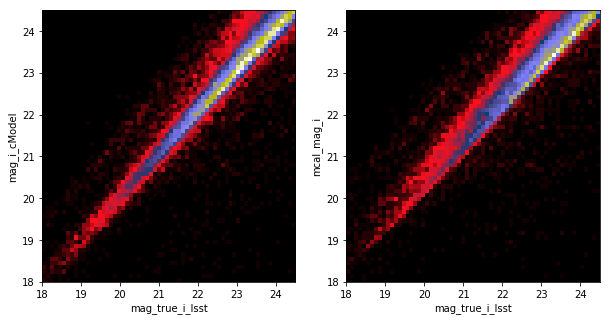

In [59]:
%pylab inline
figure(figsize=(10,5))
subplot(121)
hist2d(merged_table['mag_true_i_lsst'], merged_table['mag_i_cModel'],64,cmap='gist_stern',
       range=[[18,24.5],[18, 24.5]]);
xlabel('mag_true_i_lsst')
ylabel('mag_i_cModel')
subplot(122)
hist2d(merged_table['mag_true_i_lsst'], merged_table['mcal_mag_i'],64,cmap='gist_stern',
       range=[[18,24.5],[18, 24.5]]);
xlabel('mag_true_i_lsst')
ylabel('mcal_mag_i')

Text(0,0.5,'mcal_mag_i - mag_true_i_lsst')

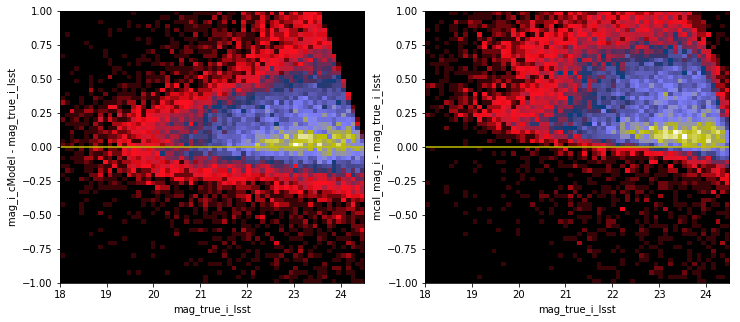

In [66]:

figure(figsize=(12,5))
subplot(121)
hist2d(merged_table['mag_true_i_lsst'], merged_table['mag_i_cModel'] - merged_table['mag_true_i_lsst'],64,cmap='gist_stern',
       range=[[18,24.5],[-1, 1]]);
xlabel('mag_true_i_lsst')
ylabel('mag_i_cModel - mag_true_i_lsst')
axhline(0,color='y')


subplot(122)
hist2d(merged_table['mag_true_i_lsst'], merged_table['mcal_mag_i'] - merged_table['mag_true_i_lsst'],64,cmap='gist_stern',
       range=[[18,24.5],[-1, 1]]);
axhline(0,color='y')

xlabel('mag_true_i_lsst')
ylabel('mcal_mag_i - mag_true_i_lsst')

Now we will measure the calibration factors we need to go from the measured HSM shapes to the catalog shapes.  We usually use a linear decomposition: $m$ and $c$.  Most shape measurement codes have been found to be linear in the weak lensing regime ([Mandelbaum et al 2015](https://arxiv.org/abs/1412.1825)), so this should be sufficient for our purposes.  That means that for a given intrinsic shape $g^{\rm true}$, what we actually measure is:

$$ g^{\rm meas} = (1+m)g^{\rm true} + c $$

The $c$ portion also has a dependence on the PSF ellipticity that we will parameterize through $\alpha$, so:

$$ g^{\rm meas} = (1+m)g^{\rm true} + \alpha e^{\rm PSF} + c $$

The proper way to do this measurement is to measure the average biases from an ensemble of shears, since what we care about is the response of the ensemble to a coherent lensing distortion of some kind.  Here, we'll do something a little simpler: just fit a linear model in the form of the previous equation. This isn't exactly right, but it should be close enough to get the right order of magnitude for our purposes.  We will also assume there is no difference between the two components of the ellipticity (which should be close enough for this exercise) as we fit for the coefficients.  To help avoid confusion, we'll call these $k_1$, $k_2$ and $k_3$ instead of $m$, $\alpha$ and $c$.

We have one final factor to take care of: the HSM shapes measure a distortion, which is a different measure of ellipticity than the one used to define the catalog ellipticities.  They differ by a factor of 2 for a shear of 0, so we will apply that factor when doing the fitting.  (See [Bernstein & Jarvis 2002](https://arxiv.org/abs/astro-ph/0107431) for more detail on this difference.)  Again, this isn't quite right--galaxies aren't round--but it will be self-consistent with our measurement method.

In [67]:
def bias_model(x, k1, k2, k3):
    xtrue = x[0]
    xpsf = x[1]
    return 2*((1+k1)*xtrue + k2*xpsf + k3)

# The EGC and object catalogs seem to have different sign conventions
e_egc_all = np.concatenate([merged_table['e1_egc'], merged_table['e2_egc']])
psf_e_all = np.concatenate([-1*merged_table['psf_e1'], merged_table['psf_e2']])
e_obj_all =  np.concatenate([-1*merged_table['e1_object'], merged_table['e2_object']])
param, _ =  op.curve_fit(bias_model, [e_egc_all, psf_e_all], e_obj_all)

k1 = param[0]
k2 = param[1]
k3 = param[2]

print("m={}, alpha={}, c={}".format(*param))

m=-0.3089084482180642, alpha=-0.00886559019199196, c=-0.00042383016831664907


(-1, 1)

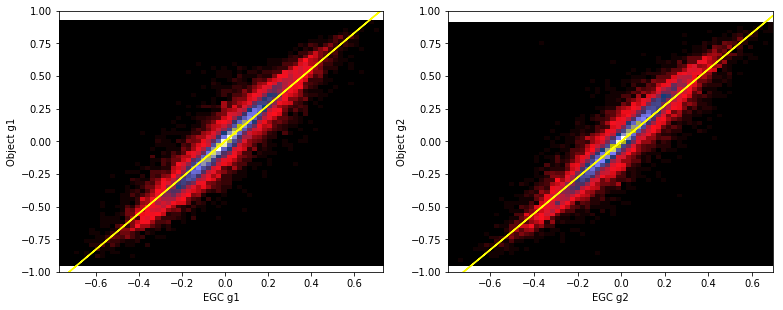

In [68]:
avg_psf_e1 = merged_table['psf_e1'].mean()
avg_psf_e2 = merged_table['psf_e2'].mean()

# Plot what these biases actually look like
fig = plt.figure(figsize=[2*figsize_x, figsize_y])
ax = fig.add_subplot(121)
ax.hist2d(merged_table['e1_egc'], -merged_table['e1_object'], bins=64, cmap='gist_stern')
ax.plot(merged_table['e1_egc'], 2*(1+k1)*merged_table['e1_egc']+k2*avg_psf_e1+k3, color='yellow')
ax.set_xlabel("EGC g1")
ax.set_ylabel("Object g1")
ax.set_ylim((-1, 1))
ax = fig.add_subplot(122)
ax.hist2d(merged_table['e2_egc'], merged_table['e2_object'], bins=64, cmap='gist_stern')
ax.plot(merged_table['e2_egc'], 2*(1+k1)*merged_table['e2_egc']+k2*avg_psf_e2+k3, color='yellow')
ax.set_xlabel("EGC g2")
ax.set_ylabel("Object g2")
ax.set_ylim((-1, 1))

Next, correlation functions. We'll use Stile to do this.  Stile's correlation function code wraps TreeCorr, but it has some built-in plotting and data-formatting functions that save us some lines of code here.

We need to define the binning for the correlation function.  I've gone for 1/5 of the extent of the catalog in declination for the max distance (possibly large enough to see edge effects anyway), using 20 bins to cover an order of magnitude in angular distance.  We'll also need to rename some columns, since Stile expects specific names.

In [29]:
# Pick some good bin edges
star_catalog = pd.DataFrame(star_catalog).dropna()
star_catalog['w'] = np.ones_like(star_catalog['ra'])
# Stile requires columns to be named certain things, and also for the data to be in a format where you can
# mask entire rows at once.  The Pandas dataframe would probably work, but we'll switch to a numpy recarray,
# which is a little more lightweight.
star_catalog_stile = star_catalog.rename(columns={'e1': 'g1', 'e2': 'g2', 'psf_e1': 'psf_g1', 'psf_e2': 'psf_g2'}).to_records()
# We still need that factor of 2!
star_catalog_stile['g1'] /= 2
star_catalog_stile['g2'] /= 2
min_ra = star_catalog['ra'].min()
max_ra = star_catalog['ra'].max()
min_dec = star_catalog['dec'].min()
max_dec = star_catalog['dec'].max()

max_sep = 0.2*(max_dec-min_dec)
min_sep = 0.1*max_sep
nbins = 20

# Make a dict of TreeCorr parameters that we can pass to Stile
corrfunc_kwargs = {'ra_units': 'degrees', 'dec_units': 'degrees',
                   'min_sep': min_sep, 'max_sep': max_sep, 'sep_units': 'degrees', 'nbins': nbins }

rho1 = stile.CorrelationFunctionSysTest("Rho1")
rho2 = stile.CorrelationFunctionSysTest("Rho2")
rho3 = stile.CorrelationFunctionSysTest("Rho3")
rho4 = stile.CorrelationFunctionSysTest("Rho4")
rho5 = stile.CorrelationFunctionSysTest("Rho5")

rho1_res = rho1(star_catalog_stile, **corrfunc_kwargs)
rho2_res = rho2(star_catalog_stile, **corrfunc_kwargs)
rho3_res = rho3(star_catalog_stile, **corrfunc_kwargs)
rho4_res = rho4(star_catalog_stile, **corrfunc_kwargs)
rho5_res = rho5(star_catalog_stile, **corrfunc_kwargs)

# When you correct correlation functions for additive and multiplicative bias, the additive is generally stable
# and can be done per-object, while the multiplicative is not stable and should be done in ensemble.  Since we measured
# m and c from the whole ensemble, though, we can just do the subtraction and division right now for m and c, and 
# because the alpha term is additive, we can do that per-object right now, too.  And again, we need to flip
# the e1 direction to make it comparable to the EGC.

merged_table['e1_object_prime'] = -(merged_table['e1_object']/2 - k3 - k2*merged_table['psf_e1'])/(1+k1)
merged_table['e2_object_prime'] = (merged_table['e2_object']/2 - k3 - k2*merged_table['psf_e2'])/(1+k1)
merged_table['w'] = np.ones_like(merged_table['ra_egc'])

merged_table_stile_obj = merged_table.rename(columns={'e1_object_prime': 'g1', 'e2_object_prime': 'g2', 'ra_object': 'ra', 'dec_object': 'dec'}).to_records()
object_corrfunc = stile.CorrelationFunctionSysTest()
object_corrfunc_res = object_corrfunc('gg', merged_table_stile_obj, **corrfunc_kwargs)

merged_table_stile_egc = merged_table.rename(columns={'e1_egc': 'g1', 'e2_egc': 'g2', 'ra_egc': 'ra', 'dec_egc': 'dec'}).to_records()
egc_corrfunc = stile.CorrelationFunctionSysTest()
egc_corrfunc_res = egc_corrfunc('gg', merged_table_stile_egc, **corrfunc_kwargs)

In [30]:
# Free up some memory
del star_catalog_stile
del merged_table_stile_egc
del merged_table_stile_obj

What do these functions look like?

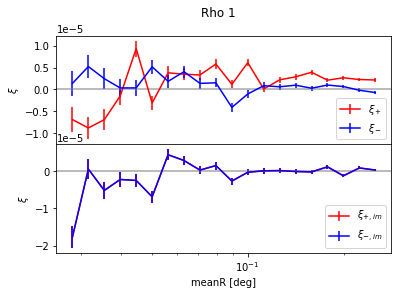

<Figure size 432x288 with 0 Axes>

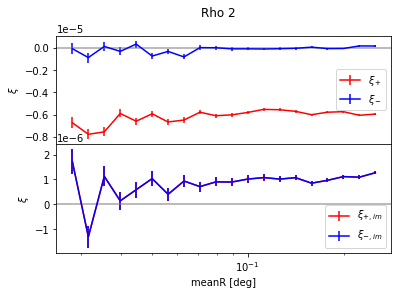

<Figure size 432x288 with 0 Axes>

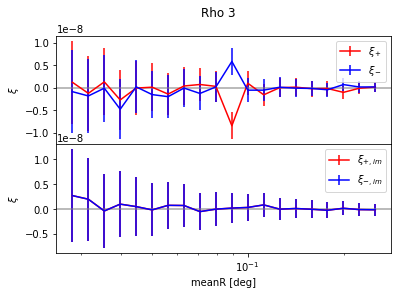

<Figure size 432x288 with 0 Axes>

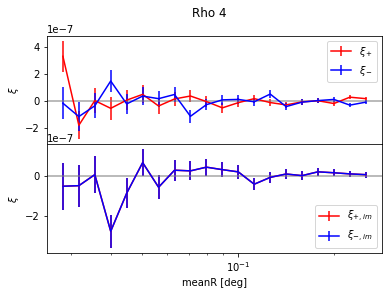

<Figure size 432x288 with 0 Axes>

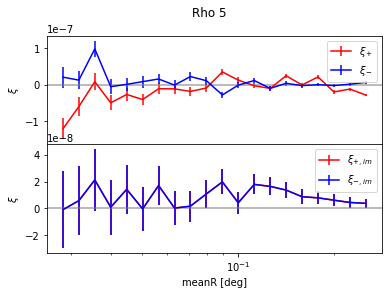

<Figure size 432x288 with 0 Axes>

In [61]:
# Note: the interface presented here will change in the near future to rho1_res.plot()
fig = rho1.plot(rho1_res)
fig.suptitle('Rho 1')
plt.clf()

fig = rho2.plot(rho2_res)
fig.suptitle('Rho 2')
plt.clf()

fig = rho3.plot(rho3_res)
fig.suptitle('Rho 3')
plt.clf()

fig = rho4.plot(rho4_res)
fig.suptitle('Rho 4')
plt.clf()

fig = rho5.plot(rho5_res)
fig.suptitle('Rho 5')
plt.clf()

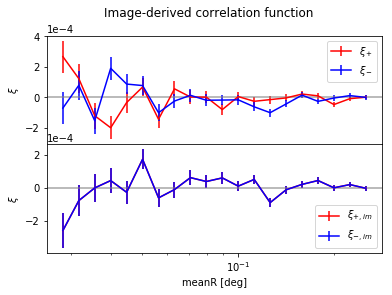

<Figure size 432x288 with 0 Axes>

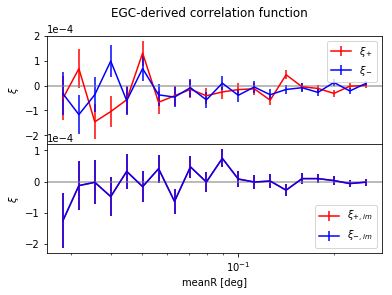

<Figure size 432x288 with 0 Axes>

In [32]:
fig = object_corrfunc.plot(object_corrfunc_res)
fig.suptitle('Image-derived correlation function')
plt.clf()

fig = egc_corrfunc.plot(egc_corrfunc_res)
fig.suptitle('EGC-derived correlation function')
plt.clf()

Following __[Jarvis et al (2015)](https://ui.adsabs.harvard.edu/#abs/arXiv:1507.05603)__, we define the correction to the correlation function as

$$ \delta \xi_+(\theta) = 2 \left\langle \frac{T_{\rm PSF}}{T_{\rm gal}} \frac{\delta T_{\rm PSF}}{T_{\rm PSF}}\right\rangle \xi_+(\theta)  +  \left\langle \frac{T_{\rm PSF}}{T_{\rm gal}} \right\rangle^2 \rho_1(\theta) - \alpha  \left\langle \frac{T_{\rm PSF}}{T_{\rm gal}}\right\rangle \rho_2(\theta) +  \left\langle \frac{T_{\rm PSF}}{T_{\rm gal}} \right\rangle^2 \rho_3 (\theta) +  \left\langle \frac{T_{\rm PSF}}{T_{\rm gal}}\right\rangle^2 \rho_4(\theta) - \alpha  \left\langle \frac{T_{\rm PSF}}{T_{\rm gal}}\right\rangle \rho_5(\theta) $$

T represents the intensity-weighted second moment of the radius, called $R^2$ in an earlier paper by Paulin-Henriksson et al. (2008).  Handily for us, the ratio of T given above is what's called resolution in the reGaussianization pipeline used for shape measurement by the DM stack.  Following Jarvis et al, we'll approximate that first expectation value as the multiplication of two expectation values:

$$\left\langle \frac{T_{\rm PSF}}{T_{\rm gal}} \frac{\delta T_{\rm PSF}}{T_{\rm PSF}}\right\rangle = \left\langle \frac{T_{\rm PSF}}{T_{\rm gal}}\right\rangle \left\langle \frac{\delta T_{\rm PSF}}{T_{\rm PSF}}\right\rangle $$

since we can't measure  the PSF modeling error at the locations of galaxies, and we can't measure galaxy size at the locations of stars.

In [93]:
alpha =k2

In [94]:
xip_object = object_corrfunc_res['xip']/(1+2*k1)
# We don't have the galaxy shapes directly, but resolution, which we *do* have, is 1-TPSF/Tgal
tpsf_tgal = np.mean(1-merged_table['ext_shapeHSM_HsmShapeRegauss_resolution'])
tpsf_tgal_deltatpsf = tpsf_tgal*np.mean((star_catalog['psf_sigma']-star_catalog['sigma'])/star_catalog['sigma'])

delta_xip = ( 2*tpsf_tgal_deltatpsf * xip_object + tpsf_tgal**2*(rho1_res['xip'] + rho3_res['xip'] + rho4_res['xip'])
             - k3*tpsf_tgal*(rho2_res['xip']+rho5_res['xip']))

And now, the comparison.  For ease of reading the plot, we're only going to plot the errorbars for the corrected object-based shape-shape correlation function.

In [ ]:
xip_gc = egc_corrfunc_res['xip']
xip_object_corrected = (xip_object + delta_xip)

xi_err_sq = (object_corrfunc_res['sigma_xi']**2*(1+4*tpsf_tgal_deltatpsf**2) + 
             tpsf_tgal**4*(rho1_res['sigma_xi']**2 + rho3_res['sigma_xi']**2 + rho4_res['sigma_xi']**2) -
             alpha**2*tpsf_tgal**2*(rho2_res['sigma_xi']**2+rho5_res['sigma_xi']**2))

x = egc_corrfunc_res['meanR [deg]']
x_edges = np.concatenate(([x[0]**2/x[1]], np.sqrt(x[:1]*x[1:]), [x[-1]**2/x[-2]]))
x_err = [x-x_edges[:-1], x_edges[1:]-x]
plt.figure(figsize=(2*figsize_x, 2*figsize_y))
plt.plot(x, np.abs(egc_corrfunc_res['xip']), label="Truth", color="C0") 
plt.errorbar(x, np.abs(xip_object_corrected), yerr=np.sqrt(xi_err_sq),
             label="object, corrected", color='C1')
plt.plot(x, np.abs(xip_object), 
             label="object", color='C2')
plt.plot(x, np.abs(2*tpsf_tgal_deltatpsf*xip_object), 
             label=r"$\xi_+$ error term", color='C3')
plt.plot(x, np.abs(tpsf_tgal**2*rho1_res['xip']), 
             label=r"$\rho_1$ error term", color='C4')
plt.plot(x, np.abs(alpha*tpsf_tgal*rho2_res['xip']), 
             label=r"$\rho_2$ error term", color='C5')
plt.plot(x, np.abs(tpsf_tgal**2*rho3_res['xip']), 
             label=r"$\rho_3$ error term", color='C6')
plt.plot(x, np.abs(tpsf_tgal**2*rho4_res['xip']), 
             label=r"$\rho_4$ error term", color='C7')
plt.plot(x, np.abs(alpha*tpsf_tgal*rho5_res['xip']), 
             label=r"$\rho_5$ error term", color='C8')

plt.legend()
plt.xlabel("R [deg]")
plt.ylabel(r"$\xi_+$")
plt.xscale('log')

We can also ask, what effect does selection have?  These previous plots were measured using only matched objects--but not all objects were matched.  Let's compute some correlation functions using *all* the objects in the given sky area.

In [ ]:
egc_catalog['w'] = np.ones_like(egc_catalog['ra_true'])
for old, new in [('ra_true', 'ra'), ('dec_true', 'dec'), ('ellipticity_1_true', 'g1'), ('ellipticity_2_true', 'g2')]:
    egc_catalog[new] = egc_catalog[old]
egc_catalog_stile = np.rec.fromarrays(egc_catalog.values(), names=list(egc_catalog.keys()))
egc_all_corrfunc = stile.CorrelationFunctionSysTest()
egc_all_corrfunc_res = egc_all_corrfunc('gg', egc_catalog_stile, **corrfunc_kwargs)

galaxy_catalog['w'] = np.ones_like(galaxy_catalog['ra'])
for old, new in [('ext_shapeHSM_HsmShapeRegauss_e1', 'g1'), ('ext_shapeHSM_HsmShapeRegauss_e2', 'g2')]:
    galaxy_catalog[new] = galaxy_catalog[old]
galaxy_catalog_stile = np.rec.fromarrays(galaxy_catalog.values(), names=list(galaxy_catalog.keys()))
galaxy_catalog_stile['g1'] = -(galaxy_catalog_stile['g1']/2 - k3 - k2*galaxy_catalog_stile['psf_e1'])/(1+k1)
galaxy_catalog_stile['g2'] = (galaxy_catalog_stile['g2']/2 - k3 - k2*galaxy_catalog_stile['psf_e2'])/(1+k1)
object_all_corrfunc = stile.CorrelationFunctionSysTest()
object_all_corrfunc_res = object_all_corrfunc('gg', galaxy_catalog_stile, **corrfunc_kwargs)

plt.figure(figsize=(2*figsize_x, 2*figsize_y))
plt.errorbar(x, object_corrfunc_res['xip'], yerr=object_corrfunc_res['sigma_xi'], label="Matched DM objects")
plt.errorbar(x, object_all_corrfunc_res['xip'], yerr=object_all_corrfunc_res['sigma_xi'], label="All DM objects")
plt.legend()
plt.xlabel("R [deg]")
plt.ylabel(r"$\xi_+$")
plt.xscale('log')

plt.figure(figsize=(2*figsize_x, 2*figsize_y))
plt.errorbar(x, egc_corrfunc_res['xip'], yerr=egc_corrfunc_res['sigma_xi'], label="Matched EGC objects")
plt.errorbar(x, egc_all_corrfunc_res['xip'], yerr=egc_all_corrfunc_res['sigma_xi'], label="All EGC objects")
plt.legend()
plt.xlabel("R [deg]")
plt.ylabel(r"$\xi_+$")
plt.xscale('log')


Finally, we can look at what shape noise does to our measurement, since we have the true shears.  To make this comparison, we have one more coefficient to care about.  We care about the response of the ensemble of shapes to an applied shear, and shears do not add linearly.  This difference is captured by what is usually called the _responsivity_, which (in the simplest case) depends on the per-component RMS distortion:

$$ \mathcal{R} \approx 1-e_{\rm rms}^2 $$

We would want this to be weighted if we were weighting galaxies, but in this tutorial, we are not.  We will need to apply this correction to our correlation functions for a proper comparison to theory.  To capture only the effects of shape noise (not measurement error or anything else), we'll compare the EGC catalog to the true shears in the EGC directly.

In [97]:
responsivity = 1-np.mean(np.concatenate([egc_catalog_stile['g1']**2, egc_catalog_stile['g2']**2]))
print("Responsivity = {}".format(responsivity))

Responsivity = 0.963523672030534


In [ ]:
# Remake the catalog again...
egc_catalog_stile['g1'] /= responsivity
egc_catalog_stile['g2'] /= responsivity
egc_all_corrfunc = stile.CorrelationFunctionSysTest()
egc_all_corrfunc_res = egc_all_corrfunc('gg', egc_catalog_stile, **corrfunc_kwargs)

egc_catalog_true = egc_catalog_stile.copy()
egc_catalog_true['g1'] = egc_catalog_true['shear_1']
egc_catalog_true['g2'] = egc_catalog_true['shear_2_treecorr']
egc_true_corrfunc = stile.CorrelationFunctionSysTest()
egc_true_corrfunc_res = egc_true_corrfunc('gg', egc_catalog_true, **corrfunc_kwargs)

plt.figure(figsize=(2*figsize_x, 2*figsize_y))
plt.errorbar(x, egc_true_corrfunc_res['xip'], yerr=egc_true_corrfunc_res['sigma_xi'], label="True shears")
plt.errorbar(x, egc_all_corrfunc_res['xip'], yerr=egc_all_corrfunc_res['sigma_xi'], label="Ellipticities")
plt.legend()
plt.xlabel("R [deg]")
plt.ylabel(r"$\xi_+$")
#plt.yscale('symlog', linthreshy=1.E-4)
plt.xscale('log')